## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera Calibration
### Compute "object points" and "image points" for camera calibration.

corners not found for ./camera_cal/calibration4.jpg
corners not found for ./camera_cal/calibration1.jpg
corners not found for ./camera_cal/calibration5.jpg


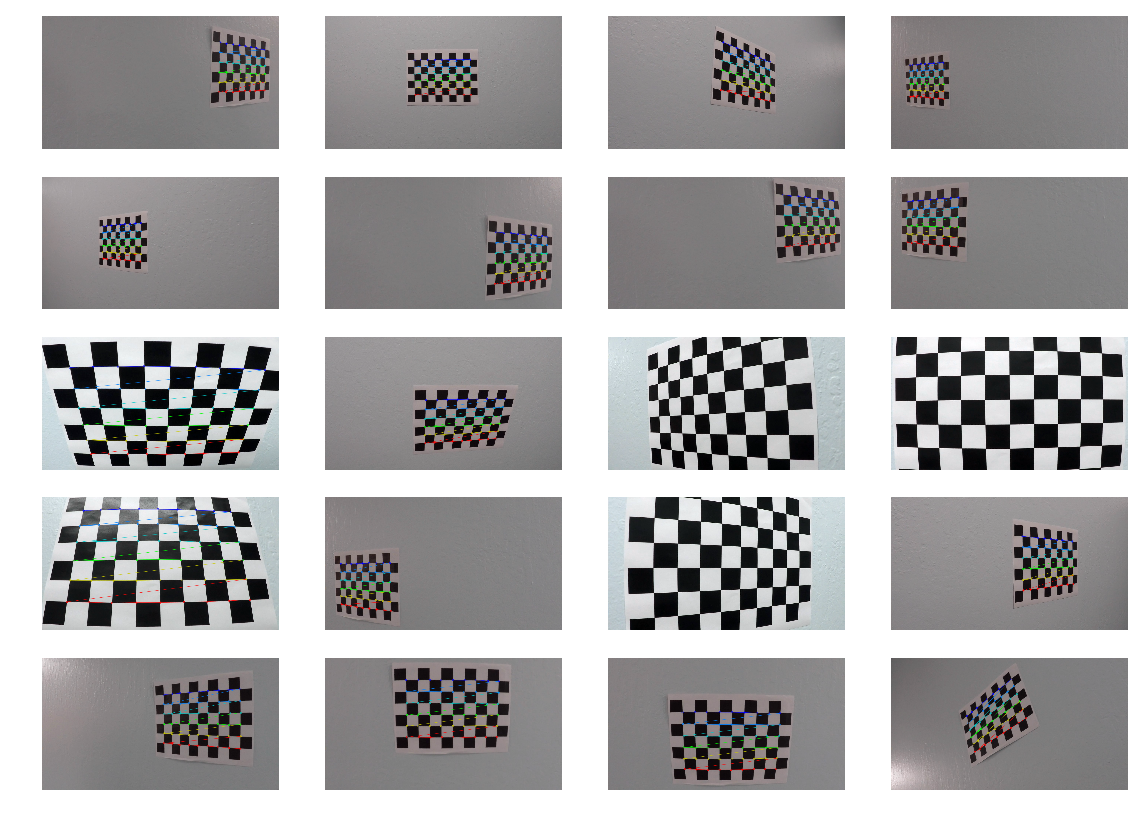

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx=9
ny=6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5,4, figsize = (14,10))
axes = axes.flatten()

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image = cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        axes[i].imshow(image)
        axes[i].axis('off')
    else:
        # print images for which no corners have been found 
        print("corners not found for " + fname)
        axes[i].imshow(image)
        axes[i].axis('off')

### Calibrate camera (get distortion coefficients and camera matrix), and test undistorting an image

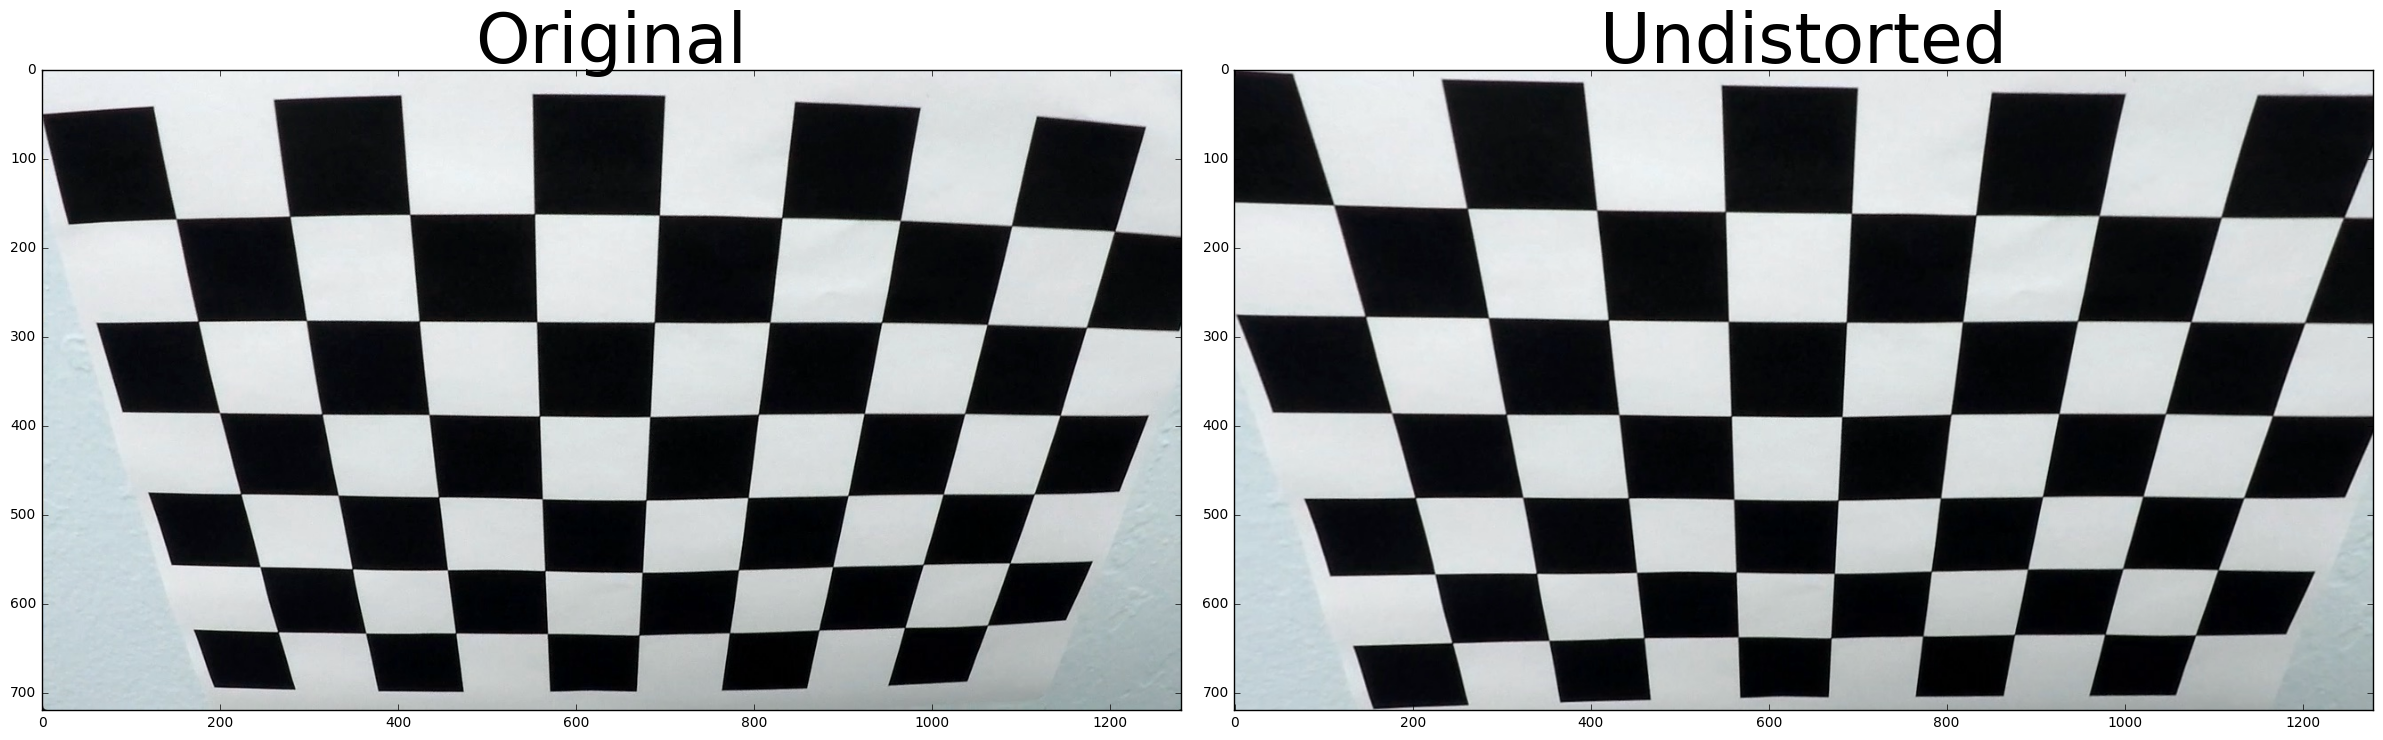

In [2]:
import pickle

# Test undistorting an image
image = cv2.imread('camera_cal/calibration2.jpg')
img_size = (image.shape[1], image.shape[0]) #(width,height)

# Perform camera calibration, given object points, image points, and the shape of the (grayscale) image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
# Undistorting a test image 
dst_image = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize original/undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original', fontsize=50)
ax2.imshow(dst_image)
ax2.set_title('Undistorted', fontsize=50)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_cal/camera_dist_pickle.p", "wb" ) )

In [3]:
# Test that the pickle file was stored correctly and can be loaded.
# Read in the saved camera matrix and distortion coefficients
with open("camera_cal/camera_dist_pickle.p", mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
# Save undistorted image to "/output_images/undistort_output.png"
image = cv2.imread('camera_cal/calibration2.jpg')
dst_image = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('output_images/undistorted_output.png', dst_image)
print("Undistorted image saved to 'output_images/undistorted_output.png'");

Undistorted image saved to 'output_images/undistorted_output.png'


# Pipeline (single images)

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

# Load the pickle file
with open("camera_cal/camera_dist_pickle.p", mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

### Provide an example of a distortion-corrected image.

Undistorted image saved to 'output_images/undistorted_road.png'


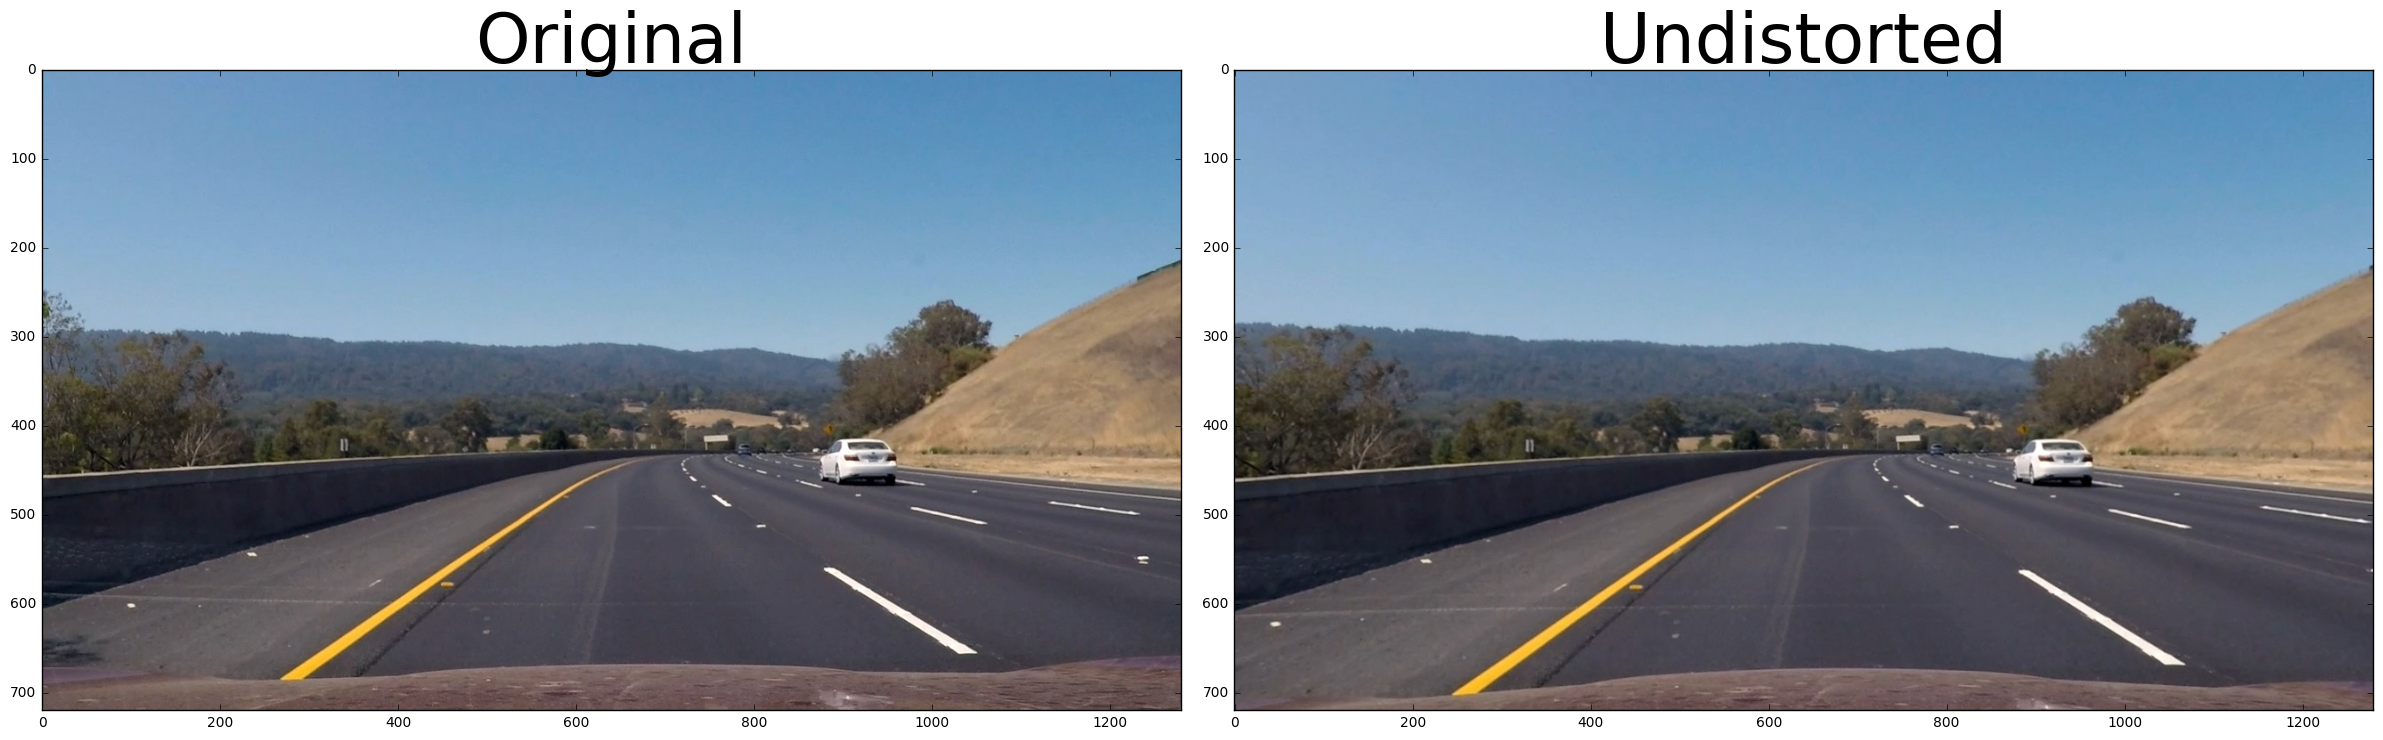

In [5]:
image = cv2.imread('test_images/test3.jpg')
#image = mpimg.imread('test_images/test1.jpg')
dst_image = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize original/undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original', fontsize=50)
ax2.imshow(cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted', fontsize=50)

# Save undistorted image to include in report
cv2.imwrite('output_images/undistorted_road.png', dst_image)
print("Undistorted image saved to 'output_images/undistorted_road.png'");

### Create a thresholded binary image.

In [6]:
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient on a grayscale image
    if orient=='y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    s_binary = np.zeros_like(abs_sobel)
    s_binary[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1

    return s_binary


def filter_noise(mask):
    # counts neighbour pixels in a 0,1 mask using a convolution with a kernel for 8-connectivity
    pixel_counts = cv2.filter2D(mask, ddepth=-1, kernel=np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]]))
    mask[pixel_counts < 4] = 0
    return mask

def binary_mask(image):
    
    s_thresh=(120, 255)
    l_thresh=(40,255)
    sx_thresh=(20, 255)    
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x 
    # Take the gradients in x, emphasize vertical lines
    sx_binary = abs_sobel_threshold(l_channel, orient='x', thresh=sx_thresh)
    
    # Threshold l (lightness) channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold s (saturation) channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #color_binary = np.uint8(255 * np.dstack((l_binary, s_binary, sx_binary)))       
    mask = np.zeros_like(sx_binary)
    mask[(((l_binary == 1) & (s_binary == 1)) | (sx_binary == 1))] = 1
    
    mask = filter_noise(mask)
    
    # TODO: add a geometric mask based on region of interest   
    
    # Returned mask is a single channel binary
    return  mask

Binary image saved to 'output_images/thresholded binary.png'


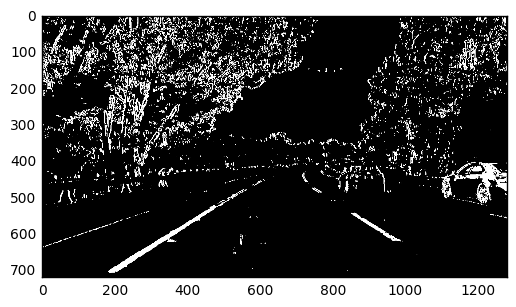

In [7]:
image = mpimg.imread('test_images/test5.jpg')
dst_image = cv2.undistort(image, mtx, dist, None, mtx)

mask = binary_mask(dst_image)
mask = np.uint8(255*np.dstack((mask, mask, mask)))
plt.imshow(mask)

cv2.imwrite('output_images/thresholded binary.png', mask)
print("Binary image saved to 'output_images/thresholded binary.png'");

### perform a perspective transform

In [8]:
# Points from a perspective image with straight lane lines.
SRC = np.float32([
    (192, 720),
    (587, 455),
    (696, 455),
    (1121, 720)])
# Mappings of source points in birdseye (warped) view.
DST = np.float32([
    (SRC[0][0] + 150, 720),
    (SRC[0][0] + 150, 0),
    (SRC[-1][0] - 150, 0),
    (SRC[-1][0] - 150, 720)])

def birdseye(image):
    # return birds eye image
    M = cv2.getPerspectiveTransform(SRC, DST)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

Original straight image with lines saved to 'output_images/straight_lines.png'
Birdseye image saved to 'output_images/straight_lines_warped.png'


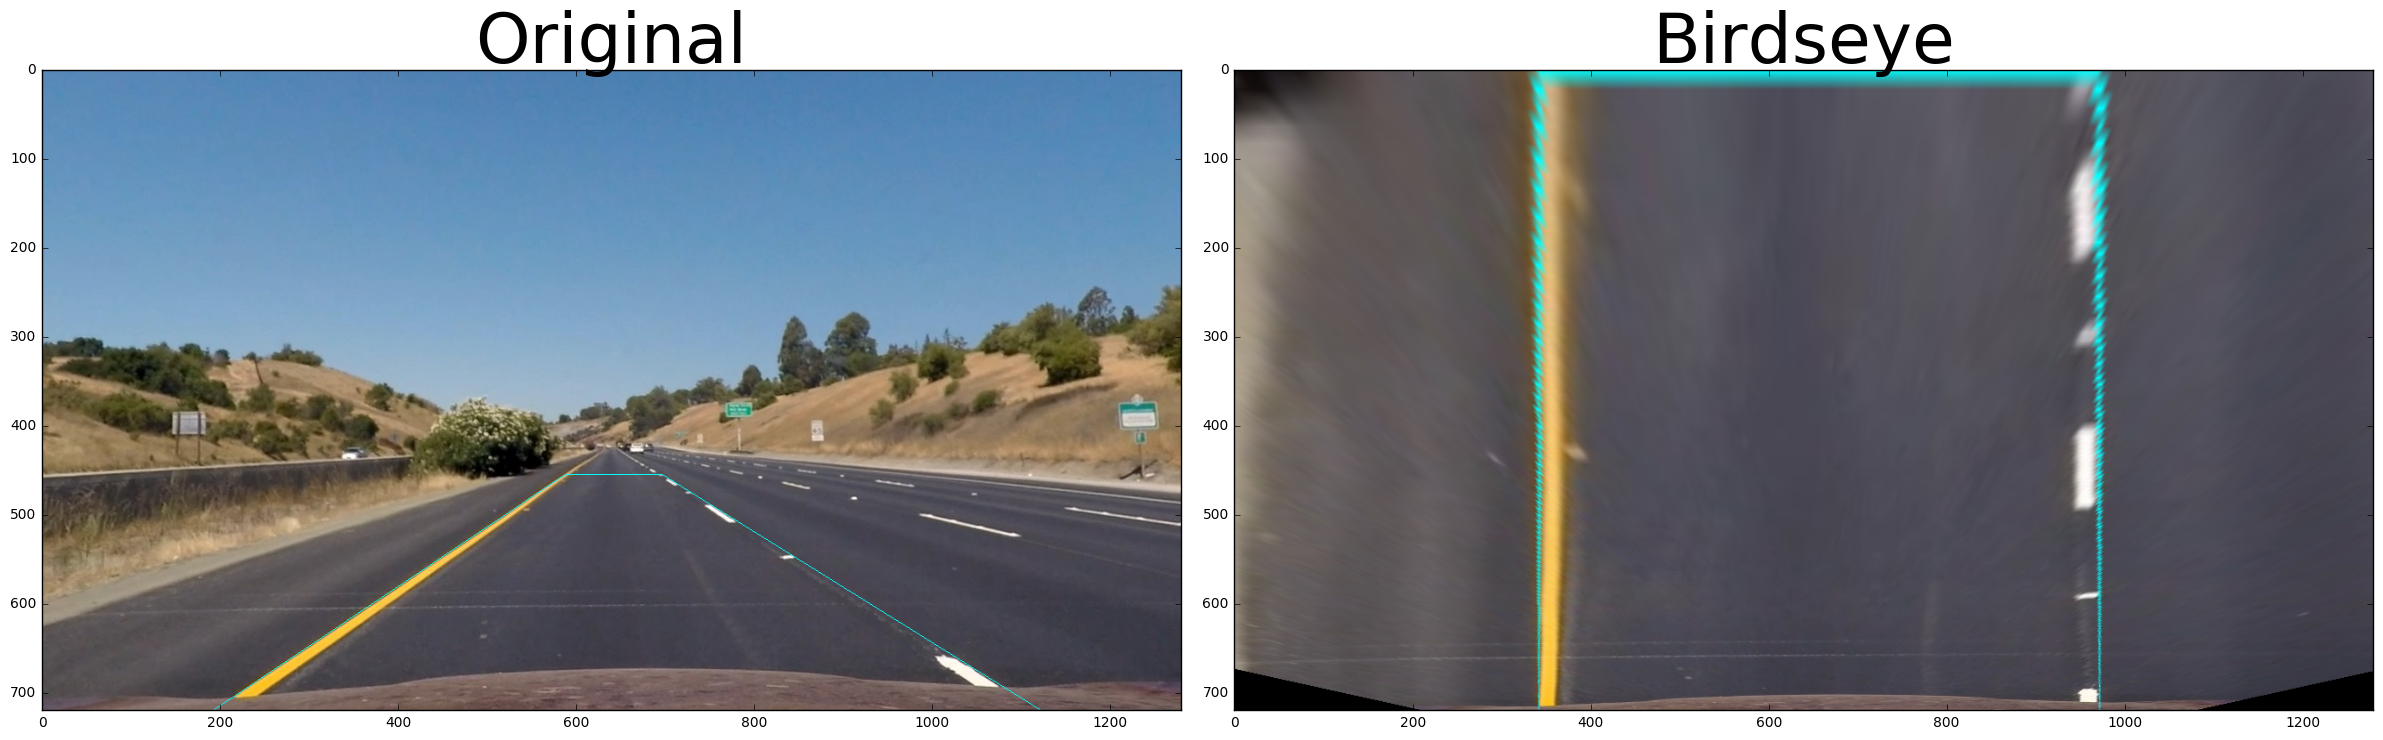

In [9]:
image = cv2.imread('test_images/straight_lines1.jpg')
dst_image = cv2.undistort(image, mtx, dist, None, mtx)
      
a = tuple(SRC[0])
b = tuple(SRC[1])
c = tuple(SRC[2])
d = tuple(SRC[3])

# draw lines
line_color=[255, 255, 0]
line_thickness=1
cv2.line(dst_image, a, b, line_color, line_thickness)
cv2.line(dst_image, b, c, line_color, line_thickness)
cv2.line(dst_image, c, d, line_color, line_thickness)
cv2.line(dst_image, d, a, line_color, line_thickness)

warped = birdseye(dst_image) # get warped image

# Visualize unwarped/warped images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original', fontsize=50)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Birdseye', fontsize=50)

# Save undistorted image to include in report
cv2.imwrite('output_images/straight_lines.png', dst_image)
print("Original straight image with lines saved to 'output_images/straight_lines.png'");
cv2.imwrite('output_images/straight_lines_warped.png', warped)
print("Birdseye image saved to 'output_images/straight_lines_warped.png'");

Binary image saved to 'output_images/birdseye_binary.png'


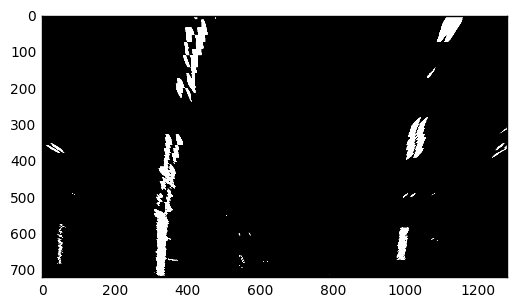

In [10]:
image = mpimg.imread('test_images/test5.jpg')
dst_image = cv2.undistort(image, mtx, dist, None, mtx)

mask = binary_mask(dst_image)

bin_warped = birdseye(mask) # get warped image

bin_warped = np.uint8(255*np.dstack((bin_warped, bin_warped, bin_warped)))

plt.imshow(bin_warped)

cv2.imwrite('output_images/birdseye_binary.png', bin_warped)
print("Binary image saved to 'output_images/birdseye_binary.png'");

### identify lane-line pixels and fit their positions

In [11]:
def get_radius_of_curvature(xs, ys, y_eval):
    """
    Evaluate the radius of curvature of a line at the bottom of the image, in meters
    :param xs: x coordites of points in the line
    :param ys: y coordites of points in the line
    :param y_eval: y coordinate where to evaluate the radius
    :return:
    """
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
                    
    # Fit polynomial to x,y points in world space
    fit_cr = np.polyfit(ys*ym_per_pix, xs*xm_per_pix, 2)
                    
    # Calculate radius of curvature
    roc = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
                    
    return roc

In [12]:
from scipy.signal import medfilt

def full_histogram_search(image):
    """Get the x-position of the base of the left and right lane lines"""

    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    
    x_margins = (int(image.shape[1]*0.084), int(image.shape[1]*0.917))
    
    # Ignore edges
    idx = [i for i in range(histogram.shape[0]) if i < x_margins[0] or i > x_margins[1]]
    histogram[idx] = 0    
    histogram = medfilt(histogram, 7)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines   
    midpoint = np.int(histogram.shape[0]/2)
    left_base_x = np.argmax(histogram[:midpoint])
    right_base_x = np.argmax(histogram[midpoint:]) + midpoint

    return left_base_x, right_base_x


left_lane_detected = False
right_lane_detected = False

def sliding_window_search(binary_warped, x_base, nwindows=7, window_width=250, debug_img=None):
    """Extract line pixel positions using a sliding window histogram search"""
    
    x_current = x_base
    
    margin = window_width//2    
       
    # Use a sliding window, placed around the line centers, 
    # to find and follow the lines up to the top of the frame.
    window_height = np.int(binary_warped.shape[0]/nwindows)
    image_height = image.shape[0]    
    
    nonzero = binary_warped.nonzero() # Get the (y,x) coordinates of the non-zero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    line_inds = []
    
    for i in range(nwindows):        
        # Identify window boundaries in x and y
        win_y_low = binary_warped.shape[0] - (i+1)*window_height
        win_y_high = binary_warped.shape[0] - i*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        side_margins = (int(binary_warped.shape[1]*0.084), int(binary_warped.shape[1]*0.917))
        
        if debug_img is not None:
            # Draw the windows on the visualization image
            cv2.rectangle(debug_img,(win_x_low, win_y_low),(win_x_high, win_y_high), (0,255,0), 2) 
            cv2.line(debug_img, (x_current, win_y_low), (x_current, win_y_high), (0,255,255), 2)
            
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                     (nonzerox >= win_x_low) & (nonzerox < win_x_high) &
                     (nonzerox >= side_margins[0]) & (nonzerox < side_margins[1])
                    ).nonzero()[0]

        # Append these indices to the list
        line_inds.append(good_inds)
        # If you found more than 50 pixels, recenter next window on their mean position
        if len(good_inds) > 55:
            x_current = np.int(np.mean(nonzerox[good_inds]))
    
    # Concatenate the arrays of indices
    line_inds = np.concatenate(line_inds)

    # Extract left and right line pixel positions
    all_x = nonzerox[line_inds]
    all_y = nonzeroy[line_inds]
    
    return all_x, all_y

def hist_lines_detector(binary_warped, debug=False):
    """Perform a sliding histogram search to detect lane lines and fit a polynomial to each"""
    
    if debug:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    else:
        out_img = None
    
    # if no past lines were detected, perform a full histogram on the bottom half of the image
    leftx_base, rightx_base = full_histogram_search(binary_warped) 
   
    left_xs, left_ys = sliding_window_search(binary_warped, leftx_base, debug_img=out_img)
    right_xs, right_ys = sliding_window_search(binary_warped, rightx_base, debug_img=out_img)
   
    # Fit a second order polynomial to each
    # Fit for f(y), rather than f(x), because the lane lines in the warped image are near vertical
    left_fit = np.polyfit(left_ys, left_xs, 2)
    right_fit = np.polyfit(right_ys, right_xs, 2)   
     
    if debug:
        # Radius of curvature is in meters
        y_eval = np.max(np.linspace(0, 719, num=10))        
        left_roc = get_radius_of_curvature(left_xs, left_ys, y_eval)   
        right_roc = get_radius_of_curvature(right_xs, right_ys, y_eval) 
        print("Left radius of curvature: ", left_roc)
        print("Right radius of curvature: ", right_roc)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # draw left line points
        out_img[left_ys, left_xs] = [255, 0, 0]
        # draw right line points
        out_img[right_ys, right_xs] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/sliding_windows.png')
        print("Binary image saved to 'output_images/sliding_windows.png'");
        
    return left_xs, left_ys, right_xs, right_ys, left_fit, right_fit

Left radius of curvature:  843.21716712
Right radius of curvature:  562.775550387
Binary image saved to 'output_images/sliding_windows.png'
Coeffs:  [  1.94765691e-04  -3.07800880e-01   4.44366587e+02] [  2.91816627e-04  -4.08005329e-01   1.13222590e+03]


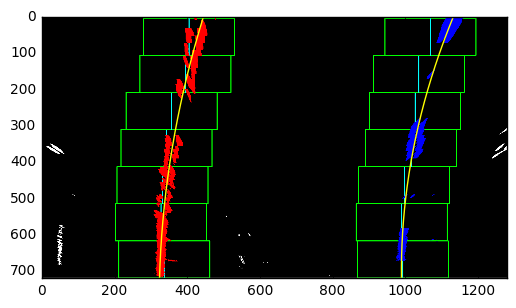

In [13]:
image = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

mask = binary_mask(undist)

binary_warped = birdseye(mask) # get warped image

_, _, _, _, left_fit, right_fit = hist_lines_detector(binary_warped, debug=True)

print("Coeffs: ", left_fit, right_fit)

In [14]:
def local_line_search(binary_warped, fit_coefs, window_width=250):
    
    """ Finds lane line points based within window_width/2 pixels (horizontally)
    from a given polynomial fit"""
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = window_width//2
    
    side_margins = (int(binary_warped.shape[1]*0.084), int(binary_warped.shape[1]*0.917))
    
    # Get a boolean array for line point positions
    line_inds = ((nonzerox > (fit_coefs[0]*(nonzeroy**2) + fit_coefs[1]*nonzeroy + fit_coefs[2] - margin)) &
                 (nonzerox < (fit_coefs[0]*(nonzeroy**2) + fit_coefs[1]*nonzeroy + fit_coefs[2] + margin)) &
                 (nonzerox >= side_margins[0]) & (nonzerox < side_margins[1]))

    # Extract left and right line pixel positions
    all_x = nonzerox[line_inds]
    all_y = nonzeroy[line_inds] 
    
    return all_x, all_y


def local_lines_detector(binary_warped, left_fit, right_fit, debug=False):
    
    """ Detect lane lines and fit a polynomial, usign a local search for lane line points
    based on most recent line fits."""

    window_width = 250

    left_xs, left_ys = local_line_search(binary_warped, left_fit, window_width)
    right_xs, right_ys = local_line_search(binary_warped, right_fit, window_width)
    
    # Fit a second order polynomial to each
    # Fit for f(y), rather than f(x), because the lane lines in the warped image are near vertical 
    left_fit = np.polyfit(left_ys, left_xs, 2)
    right_fit = np.polyfit(right_ys, right_xs, 2)
     
    if debug:
        # Radius of curvature is in meters
        y_eval = np.max(np.linspace(0, 719, num=10))        
        left_roc = get_radius_of_curvature(left_xs, left_ys, y_eval)   
        right_roc = get_radius_of_curvature(right_xs, right_ys, y_eval)        
        print("Left radius of curvature: ", left_roc)
        print("Right radius of curvature: ", right_roc)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Create an image to show the selection window        
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[left_ys, left_xs] = [255, 0, 0]
        out_img[right_ys, right_xs] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = window_width//2
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/localized_line_search.png')
        print("Binary image saved to 'output_images/localized_line_search.png'");
        
    return left_xs, left_ys, right_xs, right_ys, left_fit, right_fit

Left radius of curvature:  851.393614867
Right radius of curvature:  558.500818424
Binary image saved to 'output_images/localized_line_search.png'
Coeffs:  [  1.92895534e-04  -3.06233150e-01   4.44099923e+02] [  2.94050397e-04  -4.09934556e-01   1.13257956e+03]


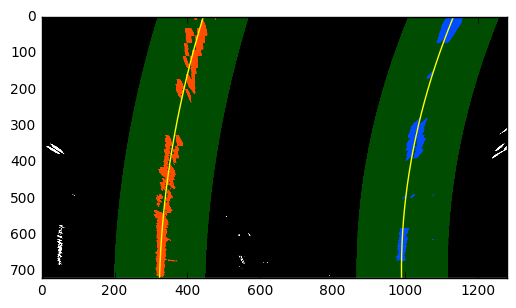

In [15]:
_, _, _, _, left_fit, right_fit = local_lines_detector(binary_warped, left_fit, right_fit, debug=True)
print("Coeffs: ", left_fit, right_fit)

In [16]:
import collections

# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self, image_size, n_frames=1):
        # number of frames for which line data will be stored
        self.n_frames = n_frames 
        # number of cached fits
        self.num_cached = 0
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_fit_xs = collections.deque(maxlen=n_frames)
        # average x values of the fitted line over the last n iterations
        self.best_xs = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # Current x values of the fitted line
        self.current_fit_xs = [np.array([False])]
        # fit coeffs of the last n fits
        self.recent_fit = collections.deque(maxlen=n_frames)      
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        #y values for evaluating polinomials
        self.fit_ys = np.linspace(0, image_size[0], num=100)
        #radius of curvature of the fitted line in meters
        self.best_radius_of_curvature = None
        #current radius of curvature in meters
        self.current_radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # Vehicle center, center of the image. 
        self.vehicle_pos = image.shape[1]//2        
        # normalized differences in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.all_xs = None  
        #y values for detected line pixels
        self.all_ys = None

          
     
    def update_diffs(self):
        # Update the diference of fit polynomial coefficients between the current fit and the last averaged fit.
        if self.num_cached > 0:
            self.diffs = (self.current_fit - self.best_fit) / self.best_fit
        else:
            self.diffs = np.array([0,0,0], dtype='float')                
                

    def validate_line(self):
        # Sanity check of lanes        
        if self.num_cached > 0:
            # Check rate of change of fit coefficients
            max_diffs = np.array([0.75,0.55,0.17])
            if not (abs(self.diffs) < max_diffs).all():
                return False
            
            # Check radius of curvature
            best_radius = self.best_radius_of_curvature
            current_radius = self.current_radius_of_curvature
            rate_of_change =  abs(current_radius - best_radius)/best_radius
            if rate_of_change > 0.5: # Allow change from frame to frame up to 200%
                return False                             
            
        if abs(self.current_line_base_pos) > 2.7:
            return False        

        return True
    
    def update_current_line_base_pos(self):
        y_eval = max(self.fit_ys)
        current_line_pos =  (self.current_fit[0]*y_eval**2 + 
                             self.current_fit[1]*y_eval + self.current_fit[2])

        xm_per_pix = 3.7/700 # meters per pixel in x dimension 
        # Positive if on right, negative on left
        self.current_line_base_pos = (current_line_pos - self.vehicle_pos)*xm_per_pix
                             
    def update_best_line_base_pos(self):
        y_eval = max(self.fit_ys)
        best_line_pos =  (self.best_fit[0]*y_eval**2 + 
                             self.best_fit[1]*y_eval + self.best_fit[2])

        xm_per_pix = 3.7/700 # meters per pixel in x dimension 
        # Positive if on right, negative on left
        self.best_line_base_pos = (best_line_pos - self.vehicle_pos)*xm_per_pix 
    
    
    def update_current_radius_of_curvature(self):        
        y_eval = np.max(self.fit_ys)        
        self.current_radius_of_curvature = get_radius_of_curvature(self.current_fit_xs, self.fit_ys, y_eval)   
    
    def update_best_radius_of_curvature(self):        
        y_eval = np.max(self.fit_ys)        
        self.best_radius_of_curvature = get_radius_of_curvature(self.best_fit_xs, self.fit_ys, y_eval)
          
    def update(self, xs, ys):

        assert(len(xs) == len(ys))
    
        # Update detected point coordinates
        self.all_x = xs
        self.all_y = ys
        
        # Update polynomial coefficients
        self.current_fit = np.polyfit(self.all_y, self.all_x, 2)
        
        # Update x values for the current fitted line
        self.current_fit_xs = (self.current_fit[0]*self.fit_ys**2 + self.current_fit[1]*self.fit_ys +
                               self.current_fit[2])
        
        # Update the relative position of the line with respect to the vehicle position (image center)
        self.update_current_line_base_pos()
        # Update the current radius of curvature
        self.update_current_radius_of_curvature()    
        
        # Update change in coefficients
        self.update_diffs()
        
        # Validate line. Check distance from center and fit coefficient differences
        valid_line = self.validate_line()
        
        if valid_line:
            # Line is valid
            self.detected=True
            # Store the data in the history queues
            self.recent_fit_xs.appendleft(self.current_fit_xs)
            self.recent_fit.appendleft(self.current_fit)
            self.num_cached = len(self.recent_fit_xs)
            self.update_averages()            
            assert(len(self.recent_fit_xs) == len(self.recent_fit))
            
        else:
            # Line is not valid, start droping data from the oldest frame
            self.detected=False            
            self.drop_data() # Drop data of the oldest frame
            assert(len(self.recent_fit_xs) == len(self.recent_fit))            
    
    
    def drop_data(self):        
        if self.num_cached > 0:
            self.recent_fit_xs.pop()
            self.recent_fit.pop()
            self.num_cached = len(self.recent_fit_xs)
            self.update_averages()
    
    def update_averages(self):
        assert(self.num_cached == len(self.recent_fit_xs))
        assert(self.num_cached == len(self.recent_fit))
        if self.num_cached > 0:    
            # Update average Xs
            if len(self.recent_fit_xs) > 0:
                self.best_fit_xs = np.mean(self.recent_fit_xs, axis=0)
                
            # Update average fit coefficients
            if len(self.recent_fit) > 0:
                self.best_fit = np.mean(self.recent_fit, axis=0)  

            # Update radius of curvature
            self.update_best_radius_of_curvature()
            # Update position relative to center                 
            self.update_best_line_base_pos()

Average Left Fit: [  1.94765691e-04  -3.07800880e-01   4.44366587e+02]
Current Left Fit: [  1.94765691e-04  -3.07800880e-01   4.44366587e+02]
Left Radius of curvature: 843.216730521
Average Right Fit: [  2.91816627e-04  -4.08005329e-01   1.13222590e+03]
Current Right Fit: [  2.91816627e-04  -4.08005329e-01   1.13222590e+03]
Right Radius of curvature: 562.775739386


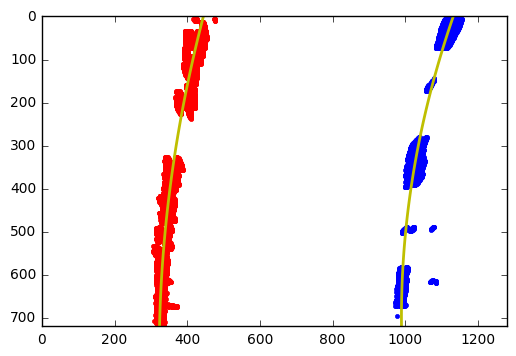

Local Search
Average Left Fit: [  1.93830613e-04  -3.07017015e-01   4.44233255e+02]
Current Left Fit: [  1.92895534e-04  -3.06233150e-01   4.44099923e+02]
Left Radius of curvature: 847.285216625
Average Right Fit: [  2.92933512e-04  -4.08969942e-01   1.13240273e+03]
Current Right Fit: [  2.94050397e-04  -4.09934556e-01   1.13257956e+03]
Right Radius of curvature: 560.630228761


In [17]:
left_line = Line(binary_warped.shape, n_frames=2)
right_line = Line(binary_warped.shape, n_frames=2)

left_xs, left_ys, right_xs, right_ys, left_fit, right_fit = hist_lines_detector(binary_warped)

left_line.update(left_xs, left_ys)
right_line.update(right_xs, right_ys)

left_ys = left_line.all_y
left_xs = left_line.all_x
left_fit_xs = left_line.current_fit_xs

print("Average Left Fit:", left_line.best_fit)
print("Current Left Fit:", left_line.current_fit)
print("Left Radius of curvature:", left_line.best_radius_of_curvature)

right_ys = right_line.all_y
right_xs = right_line.all_x
right_fit_xs = right_line.current_fit_xs

print("Average Right Fit:", right_line.best_fit)
print("Current Right Fit:", right_line.current_fit)
print("Right Radius of curvature:", right_line.best_radius_of_curvature)

yplot = left_line.fit_ys

plt.plot(left_xs, left_ys, '.', color='r')
plt.plot(left_fit_xs, yplot, color='y', linewidth=2)

plt.plot(right_xs, right_ys, '.', color='b')
plt.plot(right_fit_xs, yplot, color='y', linewidth=2)

plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

left_fit = left_line.current_fit
right_fit = right_line.current_fit
left_xs, left_ys, right_xs, right_ys, left_fit, right_fit = local_lines_detector(binary_warped, left_fit, right_fit)
left_line.update(left_xs, left_ys)
right_line.update(right_xs, right_ys)

print("Local Search")
print("Average Left Fit:", left_line.best_fit)
print("Current Left Fit:", left_line.current_fit)
print("Left Radius of curvature:", left_line.best_radius_of_curvature)

right_ys = right_line.all_y
right_xs = right_line.all_x
right_fit_xs = right_line.current_fit_xs

print("Average Right Fit:", right_line.best_fit)
print("Current Right Fit:", right_line.current_fit)
print("Right Radius of curvature:", right_line.best_radius_of_curvature)

### result plotted back down onto the road

In [18]:
def unwarp(image):
    # unwarp from bird eye to perspective
    M_inv = cv2.getPerspectiveTransform(DST, SRC)
    warped = cv2.warpPerspective(image, M_inv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def draw_lane_overlay(image, left_line, right_line, debug=False, draw_lines=False):
    # Draw the predicted lines and lane area, and unwarp it
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.best_fit_xs, left_line.fit_ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.best_fit_xs, right_line.fit_ys])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Draw lane lines only if lane was detected this frame
    if draw_lines is True:
        if left_line.detected is True:
            cv2.polylines(color_warp, np.int_([pts_left]), False, (255,0,0), thickness=20)
        if right_line.detected is True:
            cv2.polylines(color_warp, np.int_([pts_right]), False, (0,0,255), thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    if debug is True:
        plt.imshow(result)   
    
    return result

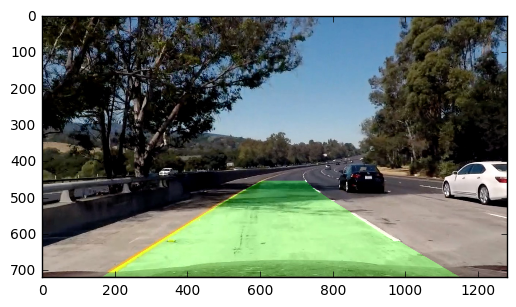

In [19]:
result = draw_lane_overlay(undist, left_line, right_line)
plt.figure()
plt.imshow(result)
plt.show()

In [20]:
def draw_info(image, left_line, right_line):
    # Draw info panel with curvature and offset from center
    
    # The curvature is the mean of the curvatures of each line
    curvature = (left_line.best_radius_of_curvature + right_line.best_radius_of_curvature)/2
        
    # Calculate offset. Lane positions are already relative to the vehicle center.
    l_pos = left_line.best_line_base_pos
    r_pos = right_line.best_line_base_pos
    offset_from_center = (r_pos + l_pos)/2
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)    
    
    cv2.putText(image, 'Radius of Curvature = {:.1f}(m)'.format(curvature),
                (50, 50), font, 1, color, 2, cv2.LINE_AA)
    cv2.putText(image, 'Vehicle is {:.3f}m of center'.format(offset_from_center),
                (50, 100), font, 1, color, 2, cv2.LINE_AA)
    
    return image
    

def process_frame(frame):  
    
    global left_line
    global right_line
    
    """ Detect lane on a single image. """

    
    
    # Apply the distortion correction.
    undist = cv2.undistort(frame, mtx, dist, None, mtx)

    # Get binary mask
    mask = binary_mask(undist)

    # Get warped image
    binary_warped = birdseye(mask) 
    
   
    if left_line.detected and right_line.detected:
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
        left_xs, left_ys, right_xs, right_ys, _, _= local_lines_detector(binary_warped, left_fit, right_fit)
    else:
        left_xs, left_ys, right_xs, right_ys, _, _ = hist_lines_detector(binary_warped)       

        
    left_line.update(left_xs, left_ys)
    right_line.update(right_xs, right_ys)
    
    # Draw overlay on the undistorted original image
    result = draw_lane_overlay(undist, left_line, right_line)
    
    result = draw_info(result, left_line, right_line) 
    
    return result

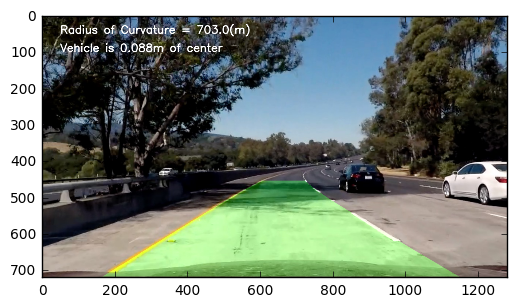

Binary final result to 'output_images/final_result.png'


In [21]:
image = mpimg.imread('test_images/test5.jpg')
left_line = Line(binary_warped.shape)
right_line = Line(binary_warped.shape)
result = process_frame(image)
plt.figure()
plt.imshow(result)
plt.show()

cv2.imwrite('output_images/final_result.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
print("Binary final result to 'output_images/final_result.png'");

## Pipeline (video)

In [22]:
from moviepy.editor import VideoFileClip



output_video_file = './project_video_out.mp4'
in_clip = VideoFileClip('project_video.mp4')
size = in_clip.size[::-1]
left_line = Line(size, n_frames=8)
right_line = Line(size, n_frames=8)
out_clip = in_clip.fl_image(process_frame) 
%time out_clip.write_videofile(output_video_file, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [04:05<00:00,  4.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 4min 51s, sys: 14.3 s, total: 5min 5s
Wall time: 4min 6s
